In [1]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19,ResNet152
from tensorflow.keras.layers import Dense,Dropout,BatchNormalization,Input,Resizing,Flatten
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras import Model
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import nibabel as nib
import os
import re
import xml.etree.ElementTree as ET
from tqdm import tqdm
from scipy.stats import entropy
from skimage.exposure import histogram

2025-06-24 14:58:32.477266: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1750777113.013798      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1750777113.128195      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
df = pd.read_csv("/kaggle/input/adni-processed/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv")

In [3]:
df

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
0,I112538,941_S_1311,MCI,M,70,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/01/2008,NiFTI,NaN
1,I97341,941_S_1311,MCI,M,70,m06,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/27/2007,NiFTI,NaN
2,I97327,941_S_1311,MCI,M,69,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,3/02/2007,NiFTI,NaN
3,I75150,941_S_1202,CN,M,78,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/24/2007,NiFTI,NaN
4,I105437,941_S_1202,CN,M,79,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,2/28/2008,NiFTI,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2289,I118671,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,4/18/2006,NiFTI,NaN
2290,I118692,002_S_0295,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled_2,Processed,11/02/2006,NiFTI,NaN
2291,I64025,002_S_0295,CN,M,86,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,5/25/2007,NiFTI,NaN
2292,I45108,002_S_0295,CN,M,85,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,4/18/2006,NiFTI,NaN


In [4]:
df.describe()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Age,Downloaded
count,2294.000000,0.0
mean,75.638622,NaN
std,6.662227,NaN
min,55.000000,NaN
25%,72.000000,NaN
50%,76.000000,NaN
75%,80.000000,NaN
max,91.000000,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2294 entries, 0 to 2293
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Image Data ID  2294 non-null   object 
 1   Subject        2294 non-null   object 
 2   Group          2294 non-null   object 
 3   Sex            2294 non-null   object 
 4   Age            2294 non-null   int64  
 5   Visit          2294 non-null   object 
 6   Modality       2294 non-null   object 
 7   Description    2294 non-null   object 
 8   Type           2294 non-null   object 
 9   Acq Date       2294 non-null   object 
 10  Format         2294 non-null   object 
 11  Downloaded     0 non-null      float64
dtypes: float64(1), int64(1), object(10)
memory usage: 215.2+ KB


In [6]:
import os

def get_all_i_folders_kaggle(root_path):
    """
    Recursively find all folders that start with 'I' and return their names.
    """
    i_folders = []
    for dirpath, dirnames, filenames in os.walk(root_path):
        for dirname in dirnames:
            if dirname.startswith('I') and dirname[1:].isdigit():
                i_folders.append(dirname)
    return i_folders

# Usage
kaggle_root = "/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed"
i_folders = get_all_i_folders_kaggle(kaggle_root)

print(f"Found {len(i_folders)} I folders:")

Found 459 I folders:


In [7]:
import pandas as pd

df = pd.read_csv("/kaggle/input/adni-processed/ADNI1_Complete_1Yr_1.5T_6_20_2025.csv")
df['Image Data ID'] = df['Image Data ID'].astype(str)

filtered_df = df[df['Image Data ID'].isin(i_folders)]
print(f"Filtered from {len(df)} → {len(filtered_df)} rows")
filtered_df = filtered_df[filtered_df['Group'] != 'MCI']
print(f"Original rows: {len(df)}, Filtered rows: {len(filtered_df)}")

Filtered from 2294 → 459 rows
Original rows: 2294, Filtered rows: 234


In [8]:
filtered_df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,Image Data ID,Subject,Group,Sex,Age,Visit,Modality,Description,Type,Acq Date,Format,Downloaded
7,I66462,941_S_1197,CN,F,82,sc,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/20/2007,NiFTI,NaN
11,I75141,941_S_1194,CN,M,85,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,8/22/2007,NiFTI,NaN
21,I92415,141_S_1137,AD,F,82,m06,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,6/26/2007,NiFTI,NaN
26,I107952,141_S_1094,CN,M,77,m12,MRI,MPR; GradWarp; B1 Correction; N3; Scaled,Processed,1/19/2008,NiFTI,NaN
42,I47744,141_S_0852,AD,F,84,sc,MRI,MPR-R; GradWarp; B1 Correction; N3; Scaled,Processed,9/25/2006,NiFTI,NaN


In [9]:
folder_path = '/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed'
paths = []
print(paths)

[]


In [10]:
import os
from tqdm import tqdm

paths = []

for subject in os.listdir(folder_path):
    subject_path = os.path.join(folder_path, subject)
    for root_dir, dirs, files in os.walk(subject_path):
        for d in dirs:
            i_folder = os.path.join(root_dir, d)
            for f in os.listdir(i_folder):
                if f.endswith(".nii") or f.endswith(".nii.gz"):
                    nii_file = os.path.join(i_folder, f)
                    row = df[df['Image Data ID'].astype(str).str.strip() == str(d).strip()]
                    if not row.empty:
                        label = row["Group"].values[0]  # Replace "Group" with actual label column name
                        paths.append((label, nii_file))
                    else:
                        print(f"No label found for: {d}")
                    break  # Only take the first .nii file per folder
print("All files scanned")

All files scanned


In [11]:
len(paths)

459

In [12]:
paths[0]

('MCI',
 '/kaggle/input/adni-processed/ADNI1_Processed/ADNI1_Processed/133_S_0913/I92637/ADNI_133_S_0913_MR_MPR__GradWarp__B1_Correction__N3__Scaled_Br_20080225185003300_S35319_I92637_mni_norm.nii')

In [13]:
scan_1 = nib.load(paths[0][1])
data_1 = scan_1.get_fdata()
header = scan_1.header
print(header)

<class 'nibabel.nifti1.Nifti1Header'> object, endian='<'
sizeof_hdr      : 348
data_type       : b''
db_name         : b''
extents         : 0
session_error   : 0
regular         : b''
dim_info        : 0
dim             : [  3 256 256 256   1   1   1   1]
intent_p1       : 0.0
intent_p2       : 0.0
intent_p3       : 0.0
intent_code     : none
datatype        : int16
bitpix          : 16
slice_start     : 0
pixdim          : [-1.  1.  1.  1.  1.  1.  1.  1.]
vox_offset      : 0.0
scl_slope       : nan
scl_inter       : nan
slice_end       : 0
slice_code      : unknown
xyzt_units      : 0
cal_max         : 0.0
cal_min         : 0.0
slice_duration  : 0.0
toffset         : 0.0
glmax           : 0
glmin           : 0
descrip         : b''
aux_file        : b''
qform_code      : unknown
sform_code      : aligned
quatern_b       : 0.0
quatern_c       : -0.70710677
quatern_d       : 0.70710677
qoffset_x       : 0.0
qoffset_y       : 0.0
qoffset_z       : 0.0
srow_x          : [-1.  0.  0.  0.

In [14]:
print(data_1.shape)
print(data_1[0,:,:])

(256, 256, 256)
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [15]:
data_1.shape[0]

256

In [16]:
filtered_paths = []
filtered_paths

[]

In [17]:
for path in paths:
    if path[0] in ('AD', 'CN'):
        filtered_paths.append(path)

In [18]:
def center_crop(image, crop_size=128):
    h, w = image.shape
    if h < crop_size or w < crop_size:
        return None
    top = (h - crop_size) // 2
    left = (w - crop_size) // 2
    return image[top:top+crop_size, left:left+crop_size]

def image_entropy(img):
    hist, _ = histogram(img)
    hist = hist / np.sum(hist)
    return entropy(hist, base=2)

In [19]:
X = []
y = []

In [20]:
for path in tqdm(filtered_paths):
    scan = nib.load(path[1])
    data = scan.get_fdata()
    label = 0 if path[0] == 'AD' else 1

    slice_info = []

    for axis in range(3):
        for i in range(data.shape[axis]):
            if axis == 0:
                slice_ = data[i, :, :]
            elif axis == 1:
                slice_ = data[:, i, :]
            else:
                slice_ = data[:, :, i]

            cropped = center_crop(slice_)
            if cropped is None:
                continue

            norm = (cropped - np.min(cropped)) / (np.max(cropped) - np.min(cropped) + 1e-6)
            ent = image_entropy(norm)
            slice_info.append((ent, norm))

    # Sort by entropy, keep top 100
    slice_info.sort(reverse=True, key=lambda x: x[0])
    top_slices = slice_info[:100]

    for _, slice_img in top_slices:
        slice_rgb = np.stack([slice_img]*3, axis=-1)  # (128, 128, 3)
        X.append(slice_rgb)
        y.append(label)

100%|██████████| 234/234 [04:57<00:00,  1.27s/it]


In [21]:
X = np.array(X, dtype='float32')
y = np.array(y, dtype='int')

In [22]:
X.shape

(23400, 128, 128, 3)

In [23]:
y.shape

(23400,)

In [24]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2)
print(len(X_train) == len(y_train))
print(len(X_test) == len(y_test))

True
True


In [25]:
input_tensor = Input(shape=(128,128,3))

In [26]:
vgg19 = VGG19(include_top=False,weights='imagenet',input_shape=(128,128,3))

I0000 00:00:1750777451.410114      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1750777451.410835      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [27]:
for layer in vgg19.layers:
  layer.trainable = False

In [28]:
x = vgg19(input_tensor)
x = Flatten()(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
x = Dense(4096,activation='relu')(x)
output_tensor = Dense(1,activation='sigmoid')(x)

In [29]:
vgg19_model = Model(inputs=input_tensor,outputs=output_tensor)
vgg19_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 128, 128, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ vgg19 (Functional)                   │ (None, 4, 4, 512)           │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 8192)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4096)                │      33,558,528 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4096)                │      16,781,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │           4,097 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 87,149,633 (332.45 MB)

 Trainable params: 67,125,249 (256.06 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [30]:
optimizer = Adam(
    learning_rate=1e-6
)
'''
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=7
)
'''

"\nearly_stop = tf.keras.callbacks.EarlyStopping(\n    monitor='val_accuracy',\n    patience=7\n)\n"

In [31]:
vgg19_model.compile(optimizer='Adam',loss=BinaryCrossentropy(),metrics=['accuracy'])

In [32]:
vgg19_history = vgg19_model.fit(x=X_train,y=y_train,batch_size=25,epochs=100,validation_split=0.1)

Epoch 1/100


I0000 00:00:1750777468.652986      99 service.cc:148] XLA service 0x7f71b4001d60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1750777468.655911      99 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1750777468.655930      99 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1750777469.322836      99 cuda_dnn.cc:529] Loaded cuDNN version 90300


  2/674 ━━━━━━━━━━━━━━━━━━━━ 51s 77ms/step - accuracy: 0.5000 - loss: 12.4517  

I0000 00:00:1750777476.052474      99 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


674/674 ━━━━━━━━━━━━━━━━━━━━ 75s 96ms/step - accuracy: 0.6521 - loss: 1.0605 - val_accuracy: 0.7714 - val_loss: 0.4812
Epoch 2/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 59s 87ms/step - accuracy: 0.7521 - loss: 0.5105 - val_accuracy: 0.7863 - val_loss: 0.4739
Epoch 3/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.7930 - loss: 0.4547 - val_accuracy: 0.8162 - val_loss: 0.4141
Epoch 4/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.8163 - loss: 0.4079 - val_accuracy: 0.8413 - val_loss: 0.3819
Epoch 5/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 59s 88ms/step - accuracy: 0.8306 - loss: 0.3729 - val_accuracy: 0.8146 - val_loss: 0.4117
Epoch 6/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.8523 - loss: 0.3374 - val_accuracy: 0.8472 - val_loss: 0.3602
Epoch 7/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.8615 - loss: 0.3142 - val_accuracy: 0.8467 - val_loss: 0.4016
Epoch 8/100
674/674 ━━━━━━━━━━━━━━━━━━━━ 60s 88ms/step - accuracy: 0.8776 - loss: 0.2803 - val_

In [33]:
vgg19_evaluation = vgg19_model.evaluate(x=X_test,y=y_test)

147/147 ━━━━━━━━━━━━━━━━━━━━ 21s 100ms/step - accuracy: 0.9349 - loss: 0.3555


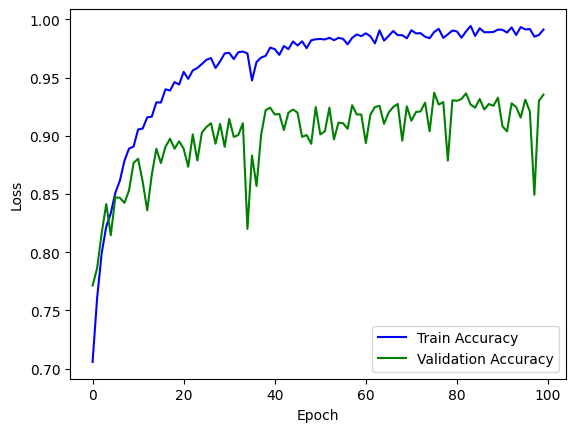

In [35]:
plt.plot(vgg19_history.history['accuracy'],color='Blue',label='Train Accuracy')
plt.plot(vgg19_history.history['val_accuracy'],color='Green',label='Validation Accuracy')
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.savefig("vgg19_100epoch.png")
plt.show()